In [4]:
os.chdir('C:\\Users\\Vishaal\\Documents\\GitHub\\Hybrid-Transfer-Learning\\Data')

In [3]:
'''

Generic Module Imports 

'''
import time
import os
import copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [5]:
'''
    Pennylane is an open source quantum machine learning package by Xanadu. Pennylane also allows to use IBMs Qiskit as an
    installed plugin. We may or may not evntually use that.
    
    Citation: 
    Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan and Nathan Killoran. 
    PennyLane. arXiv, 2018. arXiv:1811.04968
'''
import pennylane as qml
from pennylane import numpy as np # Same as standard numpy, but also does automatic differentiation

In [6]:
'''
    PyTorch is an open-source machine learning library by Facebook. It is similar to Tensorflow by Google. It's pretty 
    cool to use this to build models and import pre-trained neural nets like ResNet18. 
    
    PyTorch uses torch tensors and not numpy arrays. We may have to convert as and when necesary. 

'''

import torch
import torch.nn as nn                    #This serves as a base class for neural networks (NNs)#
import torch.optim as optim              #Contains built-in optimizer functions - like Stochastic Gradient Descent(SGD) & Adam Optimizer'''
from torch.optim import lr_scheduler     #Helps modulate learning rate based on number of epochs
import torchvision                       #PyTorchs imgage datasets and other related stuff
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [7]:
'''

    Initialize Some Parameters - For now we will use an integrated Pennylane Device. This is sort of a simulator for 
    a quantum computer. I will later attempt to use a real Quantum Computer using IBMs Q Experience but no guarantees. 
    This should not technically affect our results. Because we only use 4 qubits, the quantum simulator should have no 
    issues accurately simulating the process in polyomial time. Problems will arise for ~>50 qubits.
    
'''
n_qubits = 4              # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4             # Number of samples for each training step. This is the number of features taken in from ResNet18.
num_epochs = 30            # Number of training epochs. Set to 1 to train quickly. We will later change this to 30
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
rng_seed = 0                # Seed for random number generator
start_time = time.time()    # Start of the computation timer


In [8]:
'''
    Initialize the quantum device. Two options for names are Default & Gaussian. Shots is the number of times the circuit 
    will be run. 1024 or 2^10 is generally a good number. Wires is the number of modes to intialise the qubits in. 
    Remember qubits have a probabilistic nature and can take up various states. 
'''
dev = qml.device(name = 'default.qubit', shots = 1024, wires = 4)

In [9]:
'''
    Cuda is a parallel computing architecture created by Nvidia. The following line of code is to check if you have a GPU 
    in your computer and use it. Else, the CPU will be used.
'''
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
'''
    Directory for image data. Note the dataset is relatively small with only 250 images. We cannot train a whole classical
    or quantum CNN using such small data. However, because we are using transfer learning this would suffice to do some
    additional training. 
'''
data_dir = "..\\Data\\hymenoptera_data"

'''
    Create a dictionary of transforms we need to do to the image data. For both the training and validation set.
    Note: the values for normalise are the mean and std of the images in ImageNet (256 X 256 X 3).  
'''
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [14]:
'''
    Establish the training and validation image datasets. This is the torchvision method of loading data.
'''
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}

In [15]:
'''
    244 training images and 153 validation images in two different classes ants and bees
'''
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

In [16]:
'''
    Initialize the data loader. We don't load the data yet.
'''
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [17]:
'''
    Define a function to plot the images as they get ready
'''
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    '''
        Invert the normalisation we did before
    '''
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [18]:
'''
    The Hadamard gate applies to a single qubit in state 0 or state 1. Once applied it results in superposition and
    gives a 50% for state 0 or state 1 to exist. Basically - gives qubits their quantum nature.
    https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_(H)_gate
'''

def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
'''
    Rotates a single qubit by theta radians along the y-axis. w is a list of angles in radians you want to rotate each
    qubit by
    https://www.quantum-inspire.com/kbase/ry-gate/
    https://pennylane.readthedocs.io/en/stable/code/api/pennylane.RY.html
'''        
def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        
'''
    This is the controlled-not operator. The CNOT gate operates on two qubits at a time. For example, if the first qubit is
    in state 1, the second one is flipped two. In other words, the state of the second qubit depends on the state of the 
    first one. This is kinda what quantum entanglement is. Einstein called it spooky phenomenon and although we have 
    experimental proof, we yet don't have conclusive mathematical proof from first principles to prove this. 
'''
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])
'''
    Designing the Variational Quantum Circuit - There are three steps innvolved...
    1. Embedding - Qubits are initialised in superimposed state. They are then rotated across to input parameters.
    2. Variational Layers - A sequence of trainable rotation layers and constant entangling layers is applied.
    3. Measurement - For each qubit, the expectation of the angular momentum (Z) operator is measured. This has to be done
                     using a classical bit which can then be processed. *Most quantum phenomenon has to be measured using
                     a classical bit. This is similar to the Schrodinger's cat experiment where quanutum phenomenon is 
                     maintined till a measurement is made. 
'''
'''
    When applied to a quantum function, it turns it into a QNode instance. Because, interface is set as torch, the input and 
    output have to be torch tensors. Interface can also be set to TensorFlow.
''' 
@qml.qnode(dev, interface = 'torch')

def quantum_network(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    H_layer(n_qubits)
    '''
        Embedding
    '''
    RY_layer(q_input_features)
    '''
        Variational Layers
    '''
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])
    '''
        Measuring Expectation - PauliZ operator applies a phase flip. PauliX is bit flip.PauliY does both.
    '''
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [19]:
'''
    A dressed quantum circuit with classical pre-processing and post-processing layers
'''
class DressedQuantumNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_network(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [20]:
'''
    Creating a hybrid NN using ResNet18 and the dressed quantum circuit...
    
'''
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

In [21]:
'''
    We use cross entropy as the loss function
'''
criterion = nn.CrossEntropyLoss()

In [22]:
'''
    We use an Adam optimizer that updates the weights of our model at each step of the process. It is a derivation
    of Stohasti Gradient Descent (SGD) but differs in that it has a a per-parameter adaptive learning rate that depends
    on the average of the magnitiude of recent gradiets i.e. how fast it it changing. It can provide good results fast
    but is not always the best as SGD sometimes finds better solutions. 
'''
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [23]:
'''
    We schedule to reduce the learning rate by a factor of gamma_lr_scheduler every 10 epochs
'''
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=7, gamma=gamma_lr_scheduler)

In [25]:
'''
    Training function
'''
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    proba = []
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                scheduler.step()
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    #_ seems to have the probabilities. preds is the actual output 0/1
                    _, preds = torch.max(outputs, 1)
                    if phase == 'validation':
                        
                        proba.append(_)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return (model, proba)

In [26]:
'''
    Training our model
'''
model_hybrid, p = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)


Training started:


C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Phase: train Epoch: 1/30 Loss: 0.6246 Acc: 0.6844        
Phase: validation   Epoch: 1/30 Loss: 0.5555 Acc: 0.7582        
Phase: train Epoch: 2/30 Loss: 0.5846 Acc: 0.7008        
Phase: validation   Epoch: 2/30 Loss: 0.4765 Acc: 0.8627        
Phase: train Epoch: 3/30 Loss: 0.5272 Acc: 0.7910        
Phase: validation   Epoch: 3/30 Loss: 0.4391 Acc: 0.8758        
Phase: train Epoch: 4/30 Loss: 0.5203 Acc: 0.7787        
Phase: validation   Epoch: 4/30 Loss: 0.3927 Acc: 0.8758        
Phase: train Epoch: 5/30 Loss: 0.4152 Acc: 0.8484        
Phase: validation   Epoch: 5/30 Loss: 0.3769 Acc: 0.9216        
Phase: train Epoch: 6/30 Loss: 0.4119 Acc: 0.8607        
Phase: validation   Epoch: 6/30 Loss: 0.3170 Acc: 0.9281        
Phase: train Epoch: 7/30 Loss: 0.3995 Acc: 0.8648        
Phase: validation   Epoch: 7/30 Loss: 0.3252 Acc: 0.9085        
Phase: train Epoch: 8/30 Loss: 0.4095 Acc: 0.8607        
Phase: validation   Epoch: 8/30 Loss: 0.3061 Acc: 0.9412        
Phase: train Epo

In [36]:
model_hybrid.eval()
#real label
y = []
#scores. Calculate our pred using this
scores = []
for i, (inputs, labels) in enumerate(dataloaders['validation']):
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_hybrid(inputs)
    _, preds = torch.max(outputs, 1)
    
    sm = torch.nn.Softmax()
    probabilities = sm(outputs) 
    
    for j in range(len(labels.tolist())):
        y.append(labels.tolist()[j])
        scores.append(probabilities.tolist()[j][1])

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [40]:
a = np.zeros(len(scores))
for i in range(len(scores)):
    if scores[i] >= 0.5:
        a[i] = 1
    else:
        a[i] = 0

In [42]:
import pandas as pd 
  
# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
df = pd.DataFrame(list(zip(y, scores, a)), 
               columns =['True Label', 'Score', 'Predicted Label']) 

In [45]:
df.to_csv('C://Users//Vishaal//Documents//GitHub//Hybrid-Transfer-Learning//Report//Quantum_Validation_Scores.csv', encoding='utf-8')

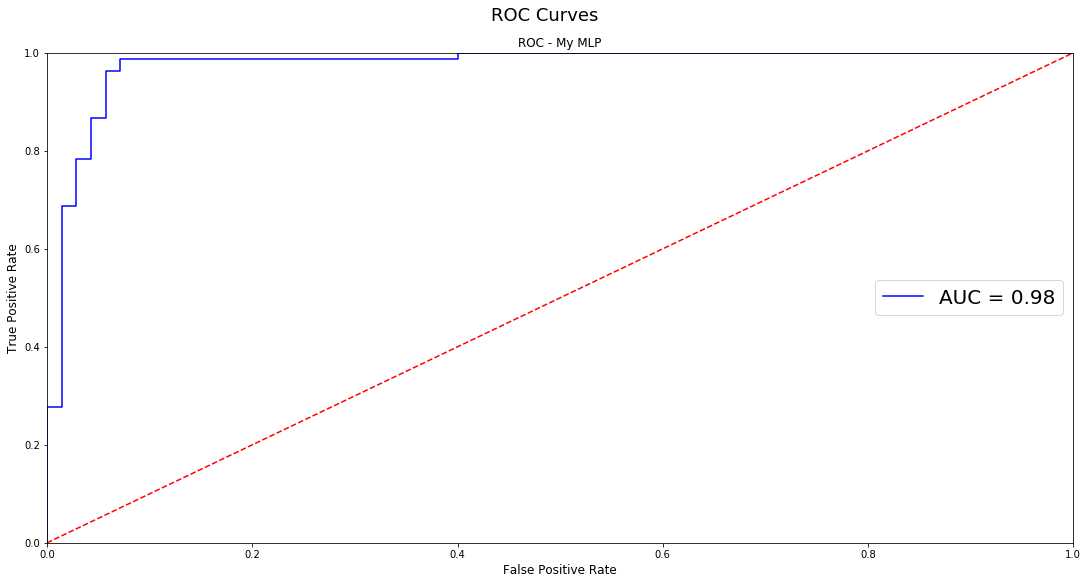

In [44]:
fig, axarr = plt.subplots(1,1, figsize=(15, 8),constrained_layout=True)
fig.suptitle("ROC Curves", fontsize=18)

fpr, tpr, threshold = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)

axarr.set_title('ROC - My MLP', fontsize=12)
axarr.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
axarr.legend(loc = 'right', fontsize=20)
axarr.plot([0, 1], [0, 1],'r--')
axarr.set_xlim([0, 1])
axarr.set_ylim([0, 1])
axarr.set_ylabel('True Positive Rate', fontsize=12)
axarr.set_xlabel('False Positive Rate', fontsize=12)
plt.savefig('C://Users//Vishaal//Documents//GitHub//Hybrid-Transfer-Learning//Plots//Quantum_ROC.png')

In [ ]:
qm_train_loss = [0.6246, 0.5846, 0.5272, 0.5203, 0.4152, 0.4119, 0.3995, 0.4095, 0.4119, 0.359,
                 0.4075, 0.4067, 0.3906, 0.4023, 0.4161, 0.3658, 0.4028, 0.401,  0.4279, 0.4008,
                 0.3772, 0.3821, 0.3438, 0.4022, 0.3714, 0.3999, 0.4075, 0.3846, 0.3838, 0.3665]

In [ ]:
qm_val_loss = [0.5555, 0.4765, 0.4391, 0.3927, 0.3769, 0.317,  0.3252, 0.3061, 0.3067, 0.3196,
               0.3041, 0.304,  0.303,  0.2959, 0.3017, 0.3007, 0.308,  0.2977, 0.3585, 0.3009,
               0.3109, 0.3007, 0.2973, 0.2974, 0.2965, 0.2972, 0.301,  0.2976, 0.3,    0.2973]